In [1]:
import os
import pickle

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import sklearn.utils

from model import FiringRateModel, PolynomialActivation
from train import train_model
from data import load_data, preprocess_data, get_train_test_data
from evaluate import explained_variance_ratio

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
def plot_kernel(model):
    # kernel for currents
    def c(x, a, lamb, w):
        n, k = a.shape
        L = torch.pow(torch.tile(lamb, dims=(k, 1)).T, x - torch.arange(1, k+1)).T
        return torch.diag(a @ L) @ w
    
    fig = plt.figure(constrained_layout=True)
    subfigs = fig.subfigures(1, 2)
    fig.suptitle(f"cell_id={cell_id}, bin_size={bin_size}, k_l={k}_{l}")
    xs = torch.linspace(0, 6, 100)
    cs, ds = [], []
    a, b, d, w = model.a, model.b, model.ds, model.w
    with torch.no_grad():
        for x in xs:
            cs.append(c(x, a, d, w))
            ds.append(c(x, b, d, w))
    
    axs0 = subfigs[0].subplots(2)
    axs0[0].plot(xs,cs)
    axs0[1].plot(xs,ds)
    axs0[0].set_ylabel("$k_a(x)$")
    axs0[1].set_ylabel("$k_b(x)$")
    axs0[1].set_xlabel("$x$")
    
    axs1 = subfigs[1].subplots(3)
    axs1[0].bar(list(range(len(model.a))), model.a.detach().reshape(-1))
    axs1[1].bar(list(range(len(model.b))), model.b.detach().reshape(-1))
    axs1[2].bar([f"{x:.2f}" for x in model.ds.tolist()], model.w.tolist())
    axs1[0].set_ylabel("$a_i$")
    axs1[1].set_ylabel("$b_i$")
    axs1[2].set_ylabel("$w_i$")
    axs1[2].set_xlabel("$i$")
    
    fig.set_size_inches(8, 5, forward=True)
    

def plot_predictions(model, Is, fs, evr=None, closed=True):    
    pred_fs, vs = model.predict(Is, closed=closed, fs=fs)
    ts = np.arange(len(Is)) * bin_size / 1000
    k, l = model.k, model.l
    fig, axs = plt.subplots(3)
    if evr is not None:
        fig.suptitle(f"({'closed' if closed else 'open'}) cell_id={cell_id}, bin_size={bin_size}, k_l={k}_{l}, evr={evr[0]:.3f}/{evr[1]:.3f}")
    else:
        fig.suptitle(f"({'closed' if closed else 'open'}) cell_id={cell_id}, bin_size={bin_size}, k_l={k}_{l}")
        
    axs[0].plot(ts, fs, label="Actual")
    axs[0].plot(ts, pred_fs, label="Predicted")
    axs[1].plot(ts, vs)
    axs[2].plot(ts, Is)
    axs[0].legend()
    axs[0].set_ylabel("firing rate")
    axs[1].set_ylabel("v")
    axs[2].set_ylabel("current (pA)")
    axs[2].set_xlabel("time (s)")
    
def train(cell_id, bin_size, k, l, save=True, static_g=True, ds=None):
    Is_tr, fs_tr, Is_te, fs_te, ws = get_train_test_data(data, cell_id, bin_size, device=device)
    Is_tr, fs_tr, ws = sklearn.utils.shuffle(Is_tr, fs_tr, ws)
    
    actv = PolynomialActivation()
    actv.init_from_file(f"model/activation/poisson/bin_size_{bin_size}/{cell_id}_0.pickle")

    model = FiringRateModel(
        actv, k=k, l=l, static_g=static_g, bin_size=bin_size, ds=ds
    ).to(device)
    
    criterion = torch.nn.PoissonNLLLoss(log_input=False)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.005, centered=True)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.85, step_size=5)

    # closed loop
    losses = train_model(
        model, 
        criterion, 
        optimizer,
        Is_tr,
        fs_tr,
        epochs = 20,
        print_every = 1,
        bin_size = bin_size,
        up_factor = 1,
        ws = ws,
        C = 1,
        scheduler = scheduler
    )
    
    return model

In [12]:
data = load_data(with_zero=True)
data.keys()

dict_keys([583836069, 565871768, 605889373, 513593674, 504615116])

In [13]:
for cell_id in data:
    print(cell_id)
    counts = {}
    for sweep in data[cell_id][:-1]:
        stim_name = sweep["stimulus_name"]
        if stim_name not in counts:
            counts[stim_name] = 0
        counts[stim_name] += 1
    print(counts)

583836069
{'Short Square': 9, 'Long Square': 22, 'Ramp': 2, 'Noise 1': 3, 'Noise 2': 4, 'Square - 0.5ms Subthreshold': 10, 'Test': 1}
565871768
{'Short Square': 13, 'Long Square': 36, 'Ramp': 1, 'Noise 2': 4, 'Noise 1': 2, 'Square - 0.5ms Subthreshold': 10, 'Square - 2s Suprathreshold': 12, 'Test': 1}
605889373
{'Short Square': 17, 'Long Square': 37, 'Ramp': 3, 'Noise 1': 3, 'Noise 2': 3, 'Square - 0.5ms Subthreshold': 10, 'Test': 1}
513593674
{'Short Square': 29, 'Long Square': 25, 'Square - 2s Suprathreshold': 13, 'Ramp to Rheobase': 3, 'Short Square - Hold -70mV': 14, 'Test': 1, 'Ramp': 3, 'Noise 1': 4, 'Noise 2': 4, 'Square - 0.5ms Subthreshold': 2, 'Short Square - Triple': 21}
504615116
{'Short Square': 26, 'Square - 2s Suprathreshold': 6, 'Ramp to Rheobase': 1, 'Test': 1, 'Long Square': 24, 'Ramp': 3, 'Noise 1': 4, 'Noise 2': 3, 'Square - 0.5ms Subthreshold': 2, 'Short Square - Triple': 13}


In [14]:
cell_id, bin_size, k, l = 504615116, 20, 1, 1
ds = np.linspace(0.2, 1, 9)
params = {}

model = train(cell_id, bin_size, k, l, save=False, static_g=True, ds=ds)
if cell_id not in params:
    params[cell_id] = {}
if bin_size not in params[cell_id]:
    params[cell_id][bin_size] = {}
params[cell_id][bin_size][(k, l)] = model.get_params()

#with open('model/params.pickle', 'wb') as handle:
#    pickle.dump(params, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1 / Loss: 220.25552332823955 / lr: [0.005]
Epoch 2 / Loss: 139.75894702942327 / lr: [0.005]
Epoch 3 / Loss: 155.4514490663289 / lr: [0.005]
Epoch 4 / Loss: 142.51885868883573 / lr: [0.005]
Epoch 5 / Loss: 163.32577316866568 / lr: [0.00425]
Epoch 6 / Loss: 139.2960700006821 / lr: [0.00425]
Epoch 7 / Loss: 136.51742550957567 / lr: [0.00425]
Epoch 8 / Loss: 208.29570545222708 / lr: [0.00425]
Epoch 9 / Loss: 219.74857750508735 / lr: [0.00425]
Epoch 10 / Loss: 137.36225423947553 / lr: [0.0036125000000000003]
Epoch 11 / Loss: 128.60071674490774 / lr: [0.0036125000000000003]
Epoch 12 / Loss: 161.90709309232165 / lr: [0.0036125000000000003]
Epoch 13 / Loss: 135.5917410941747 / lr: [0.0036125000000000003]
Epoch 14 / Loss: 124.25432204612746 / lr: [0.0036125000000000003]
Epoch 15 / Loss: 119.1107156652814 / lr: [0.003070625]
Epoch 16 / Loss: 125.19714596213247 / lr: [0.003070625]
Epoch 17 / Loss: 121.99583828867154 / lr: [0.003070625]
Epoch 18 / Loss: 123.55777762844586 / lr: [0.003070625]

/var/folders/1d/cmypn_251jlfyvc132scjqd40000gp/T/ipykernel_89919/3646578465.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3)


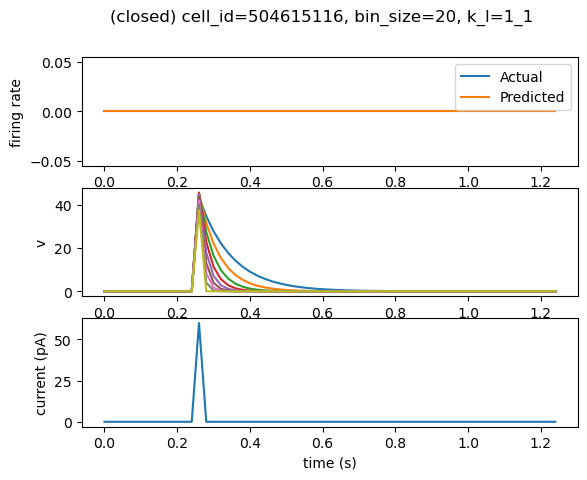

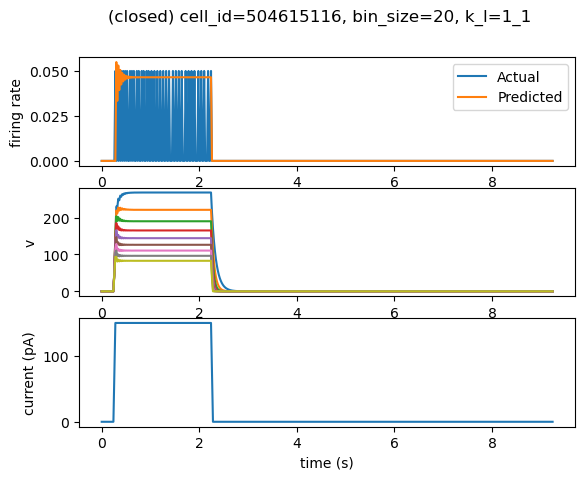

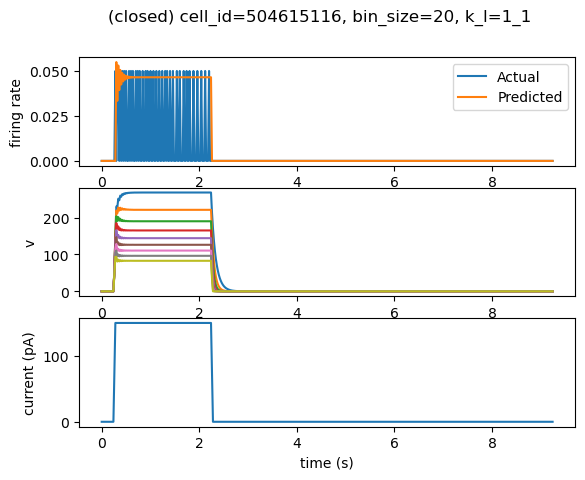

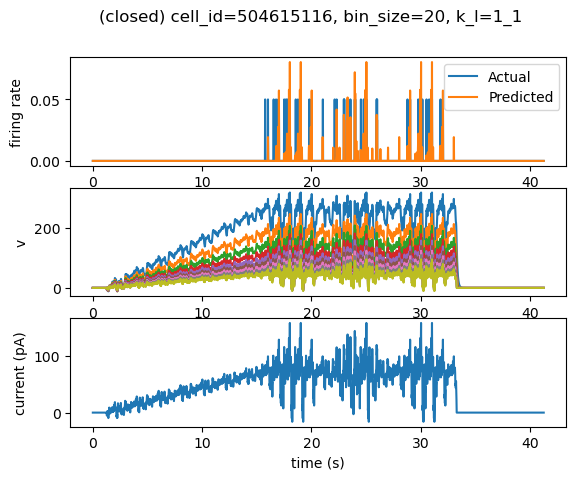

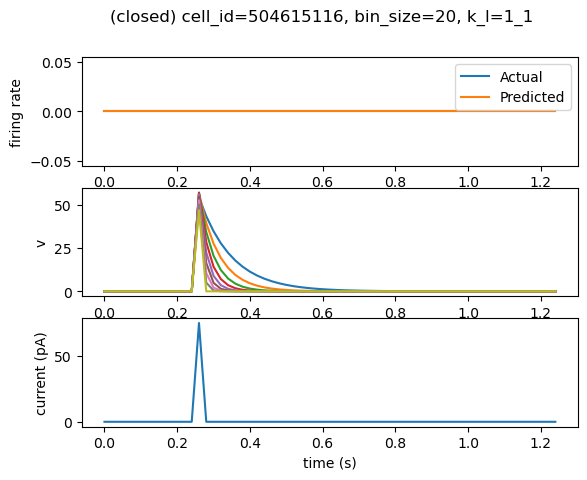

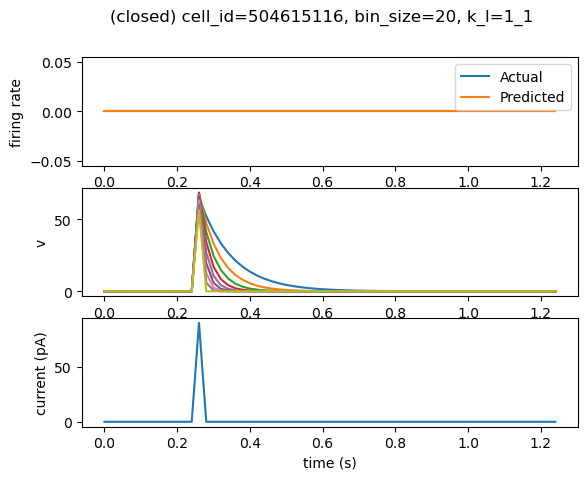

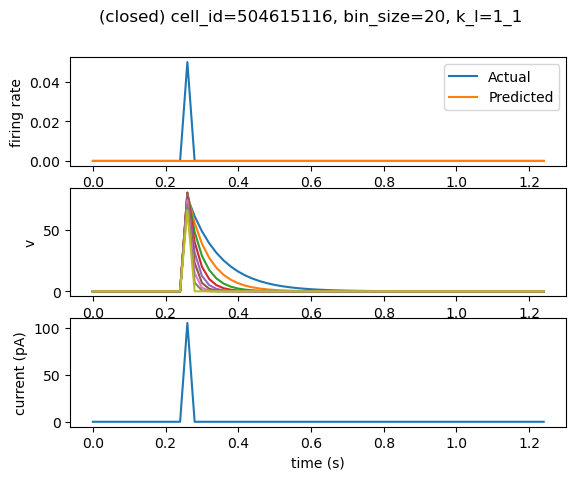

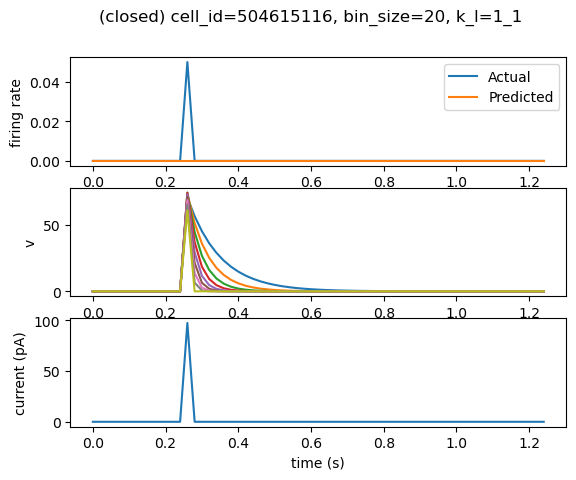

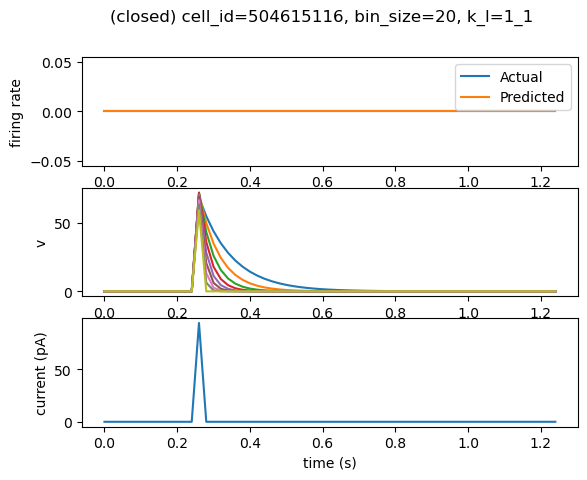

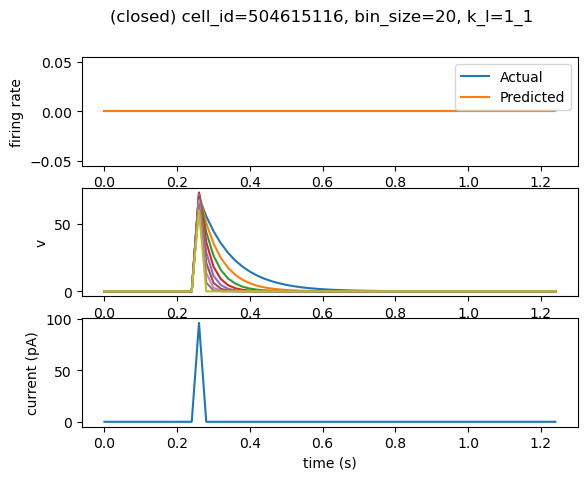

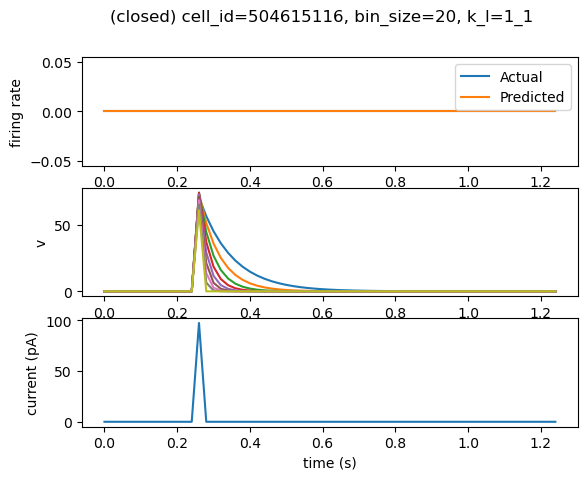

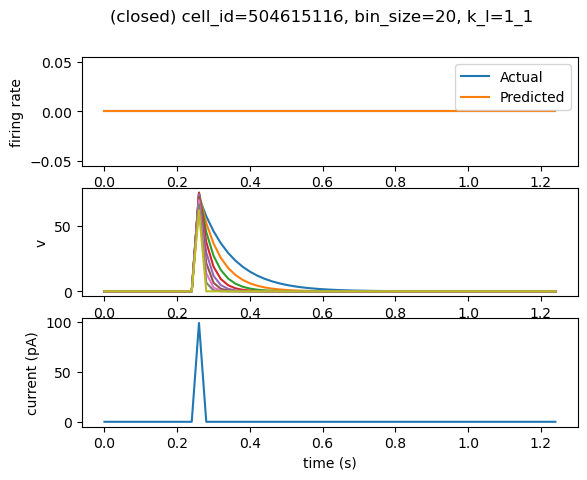

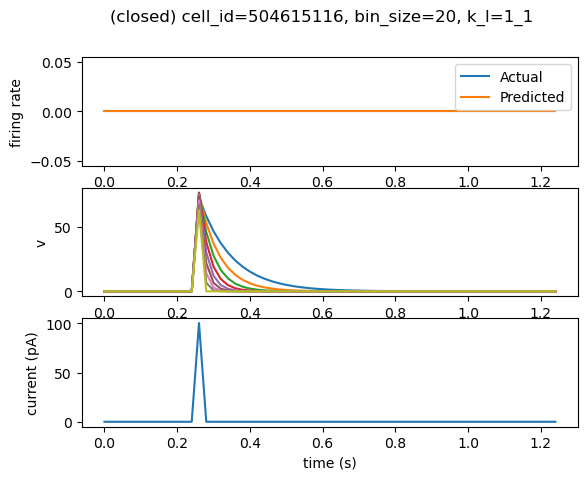

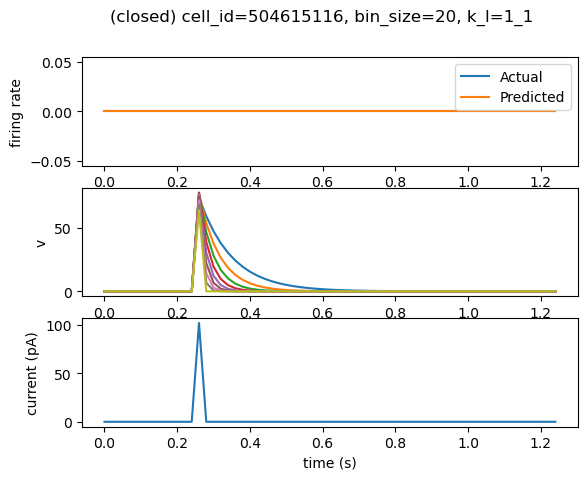

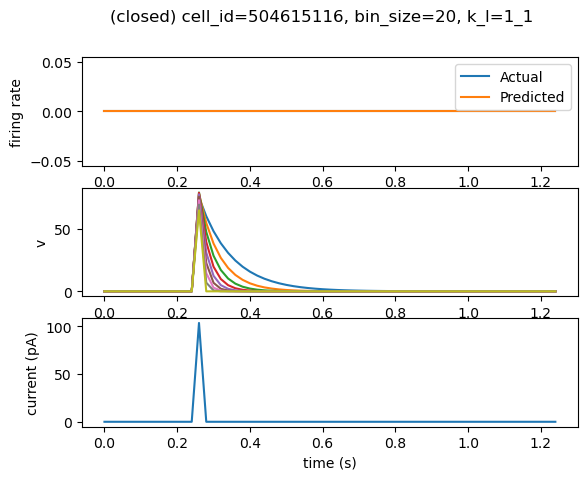

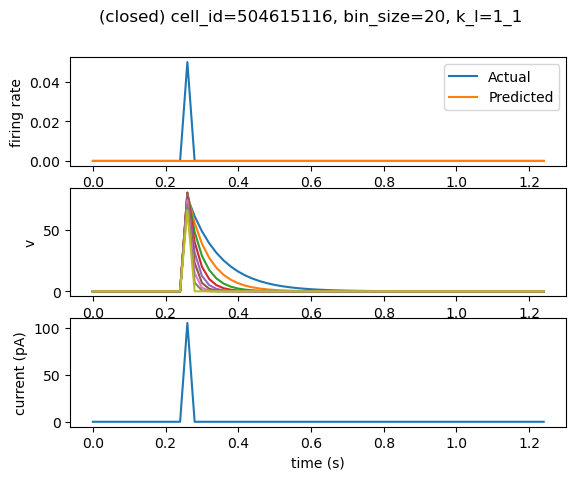

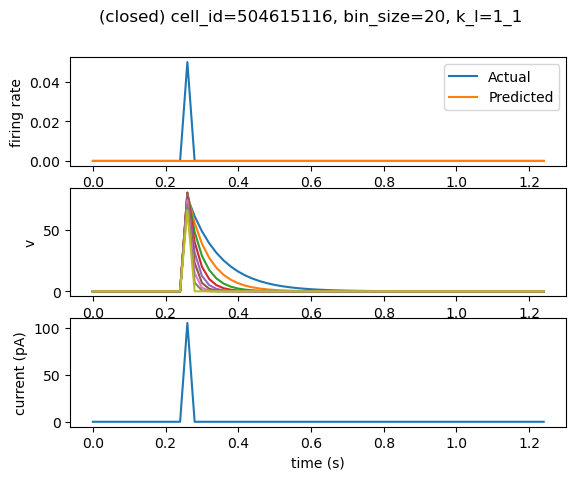

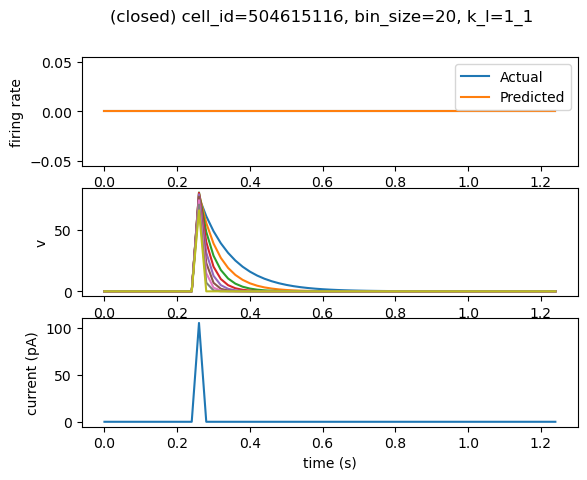

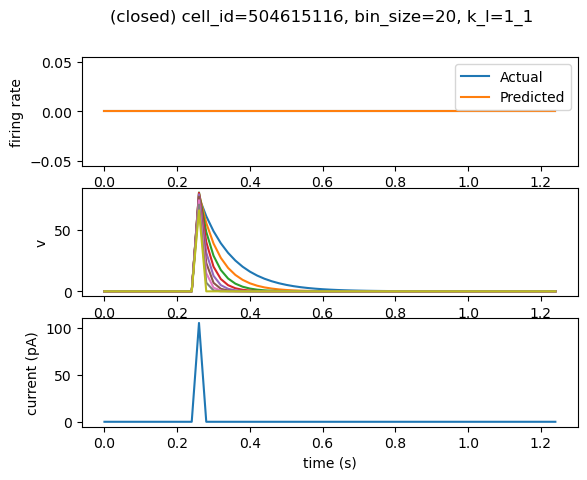

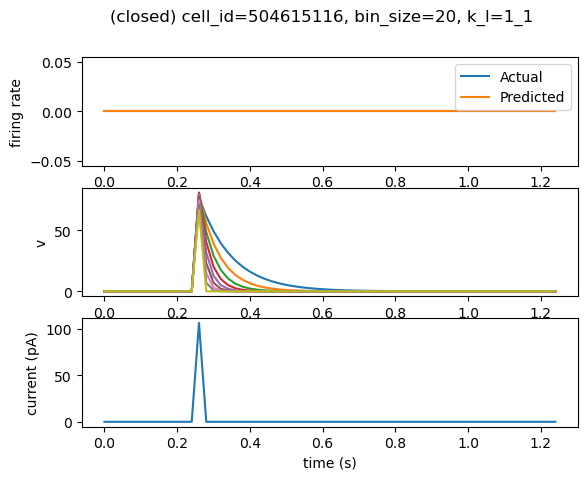

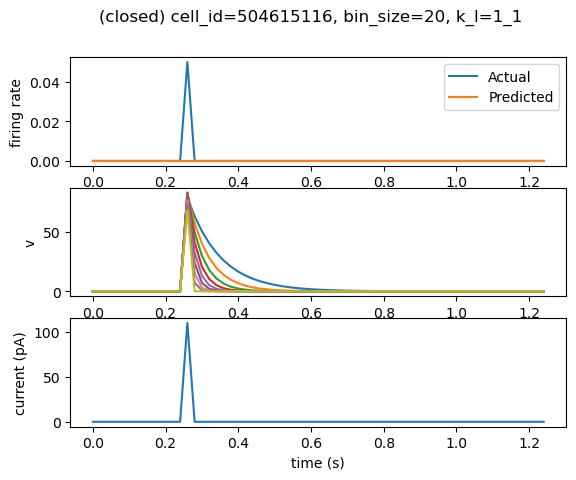

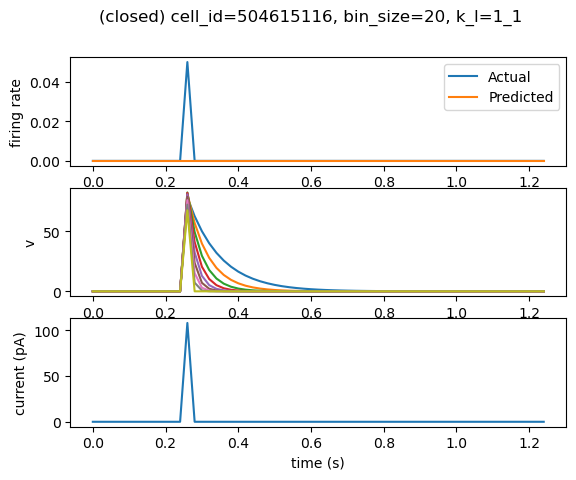

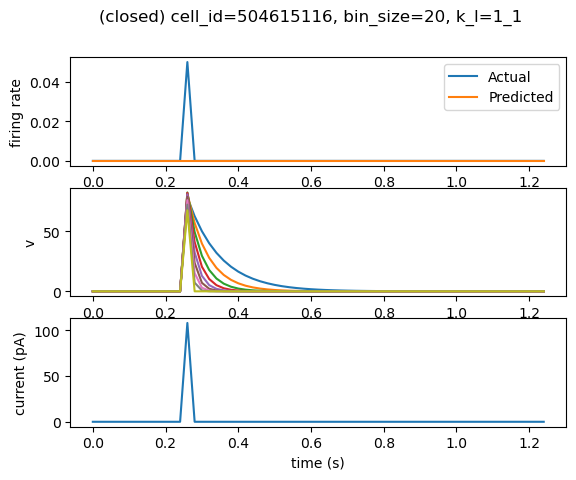

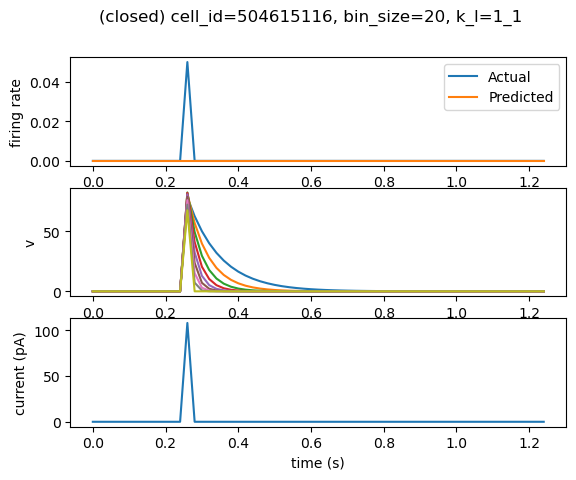

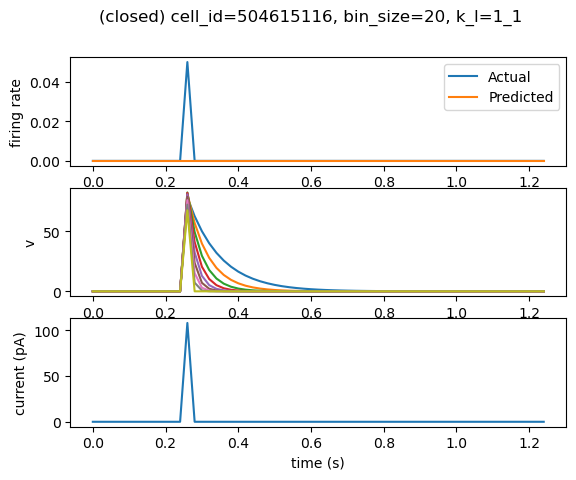

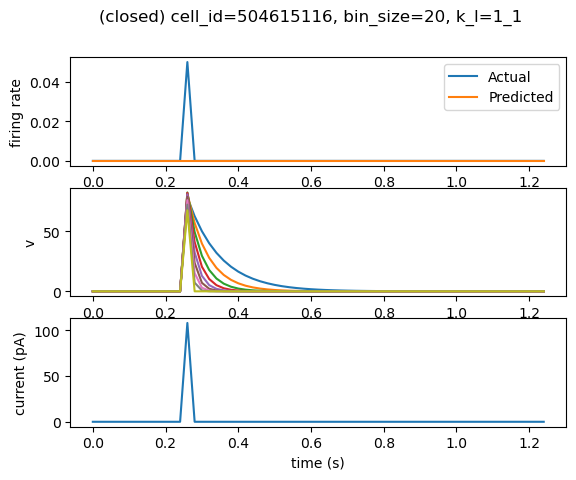

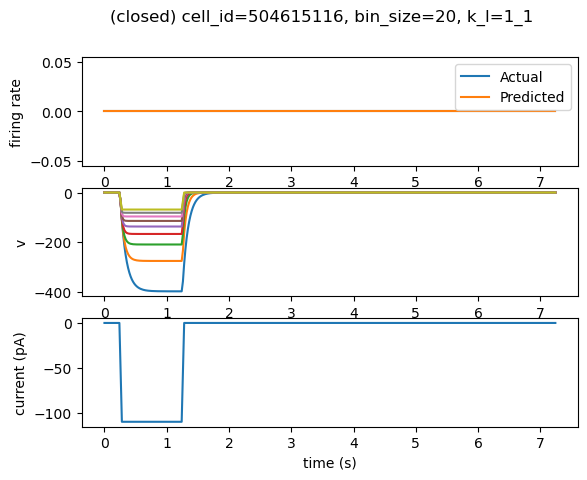

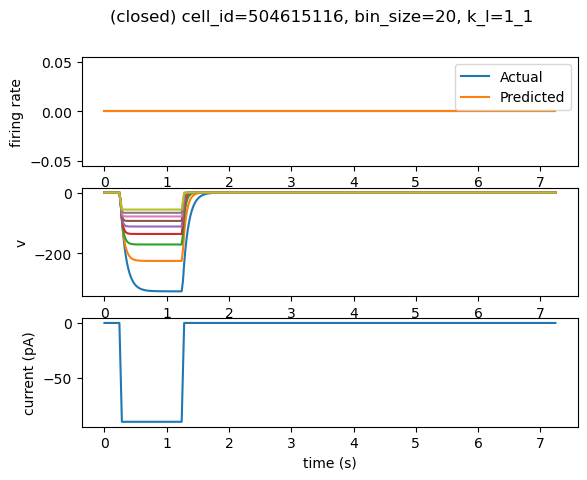

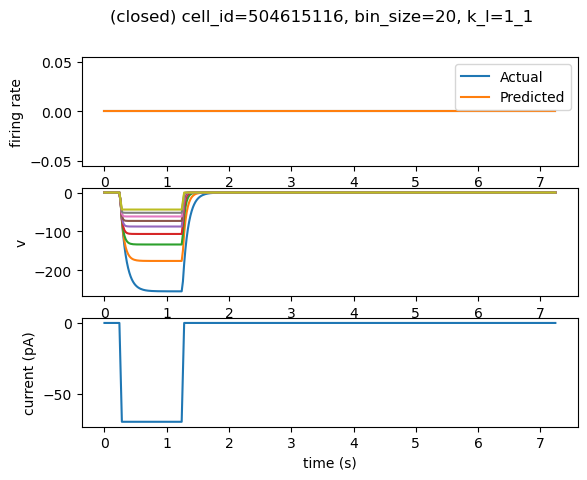

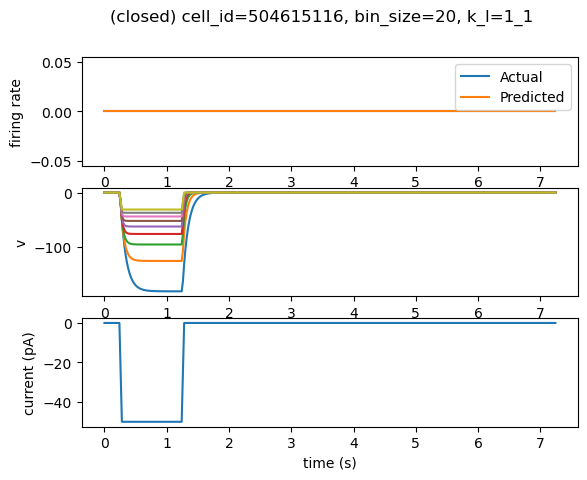

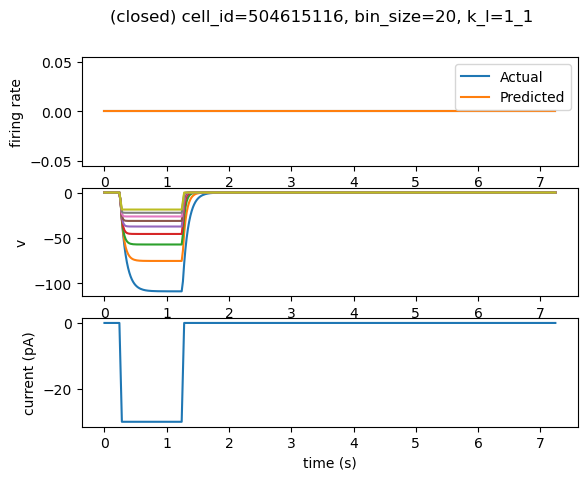

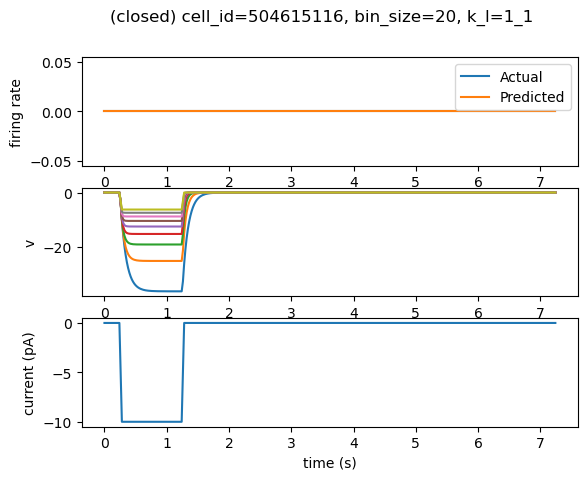

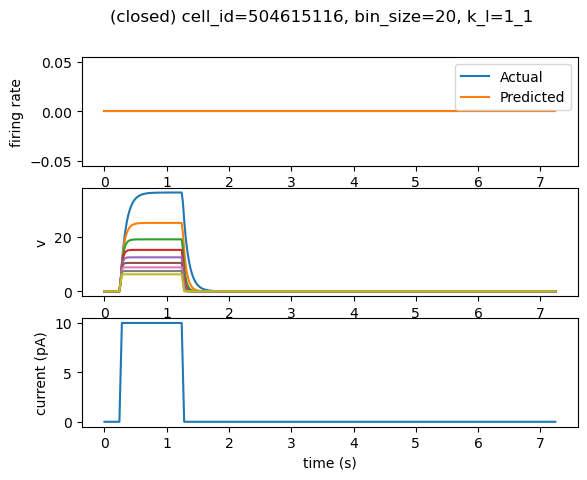

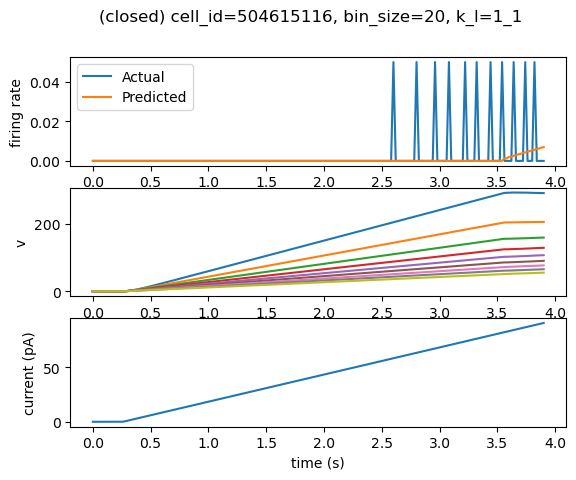

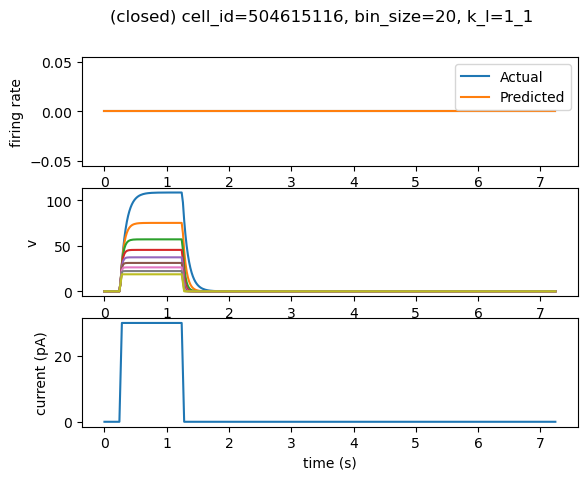

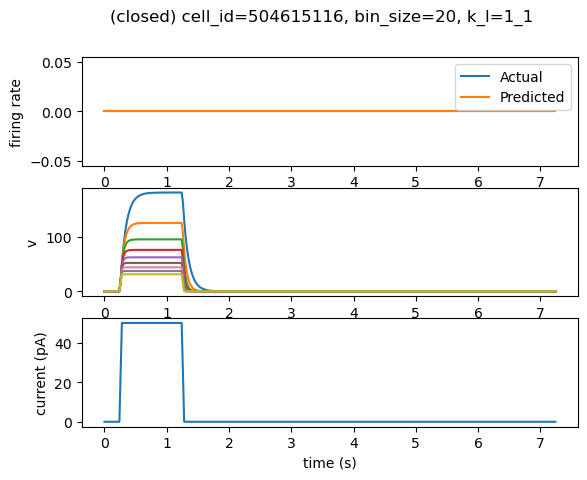

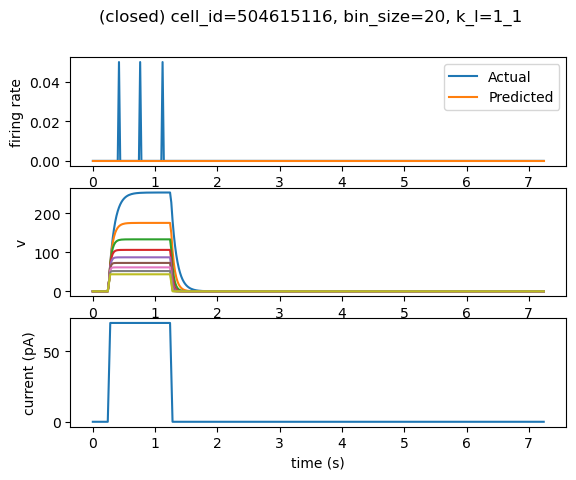

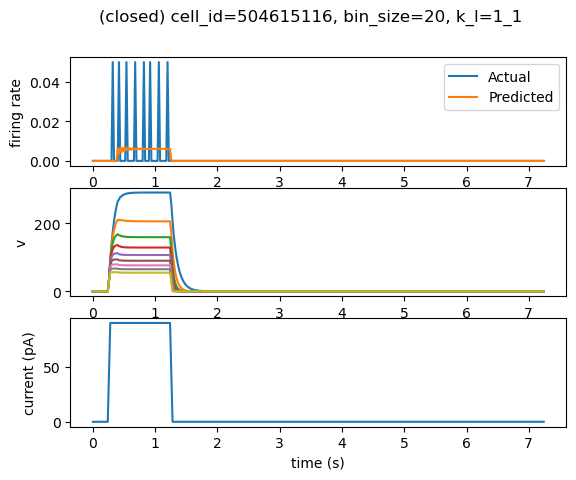

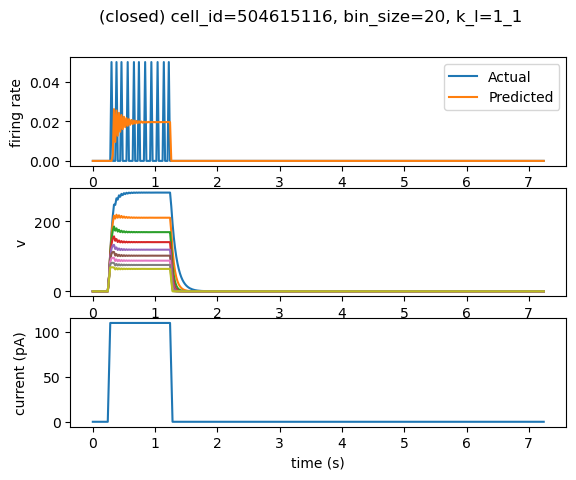

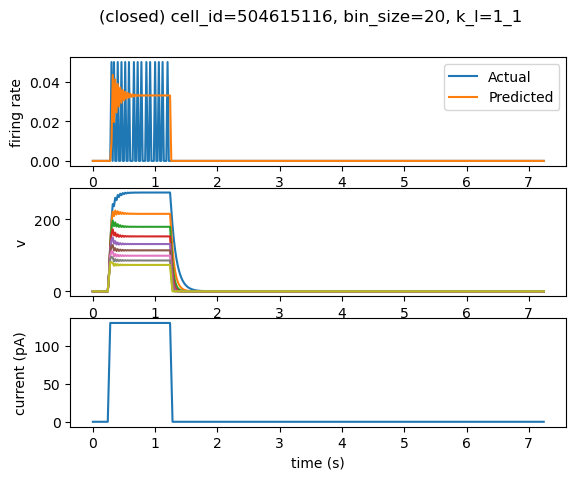

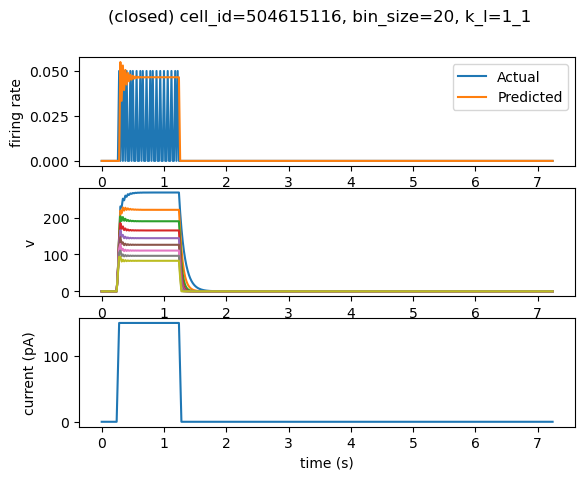

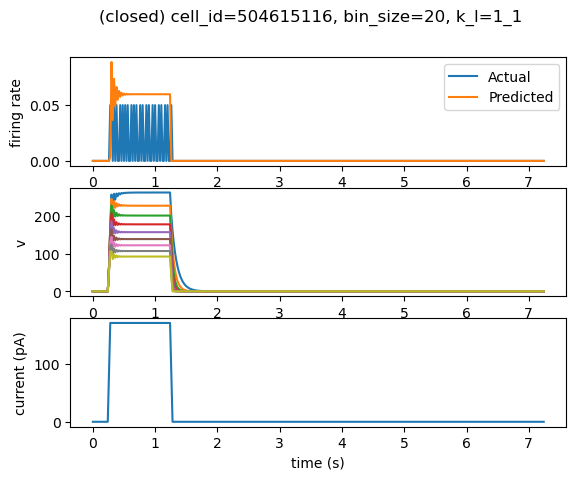

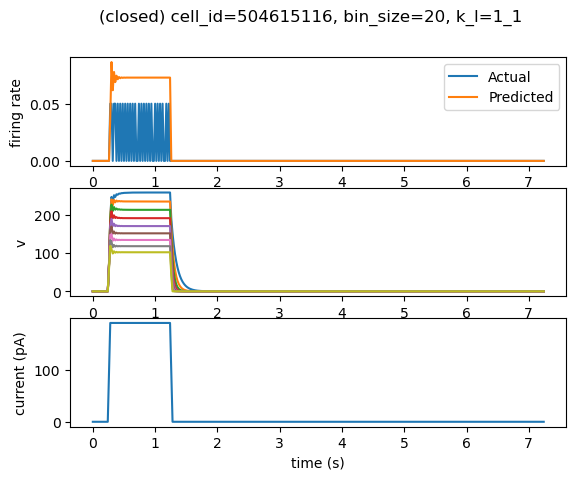

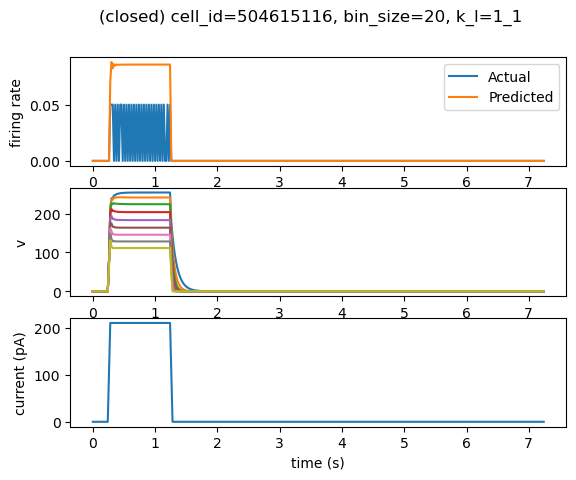

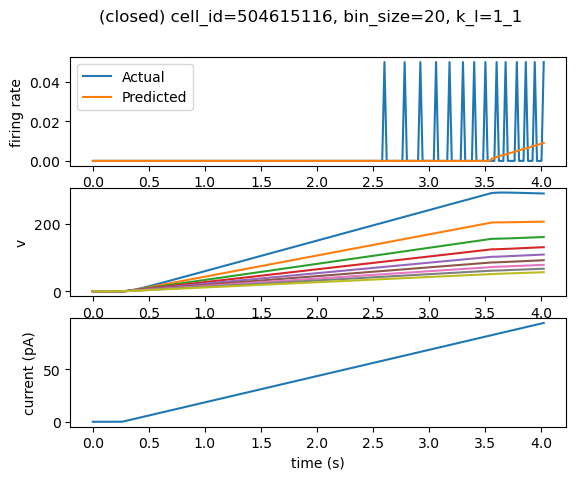

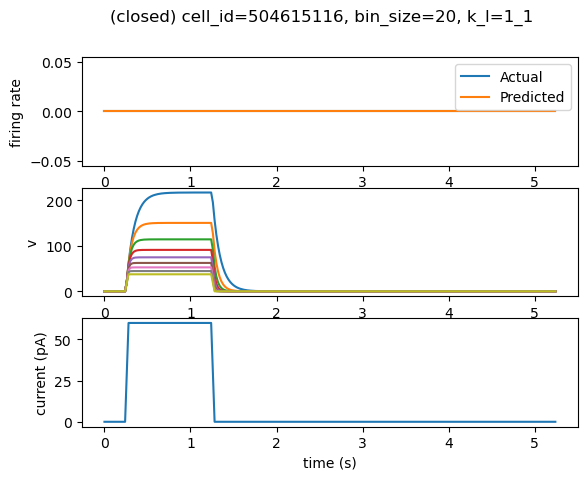

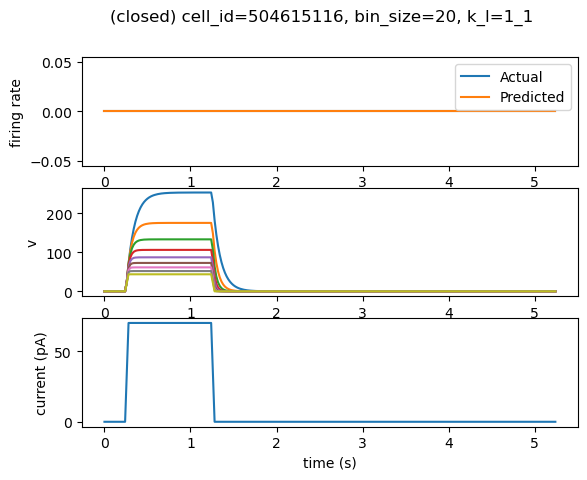

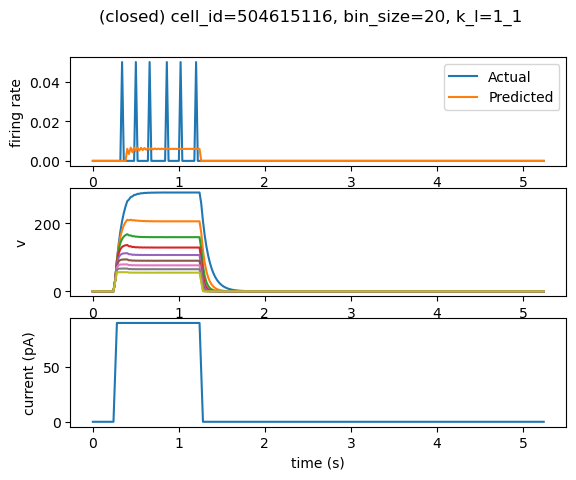

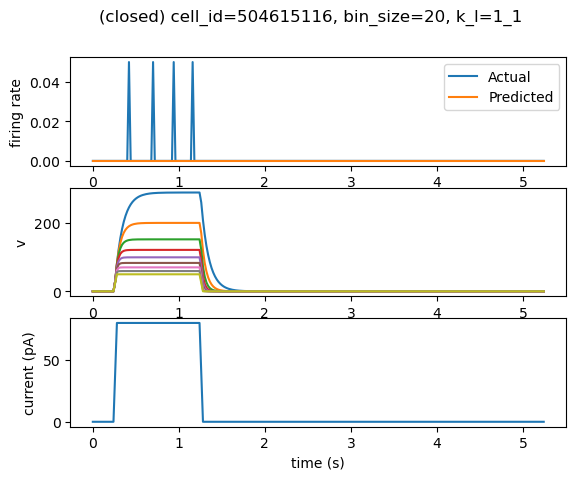

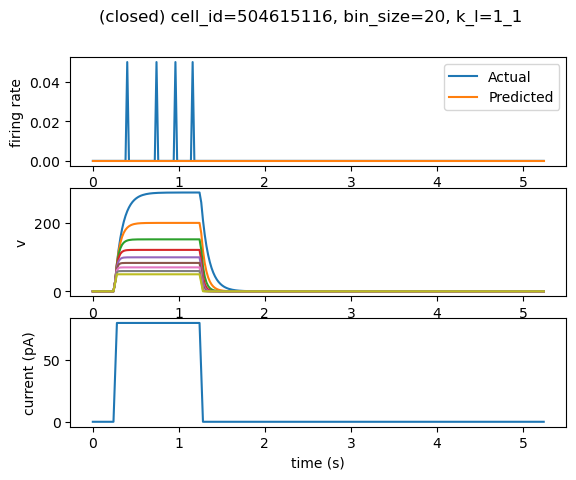

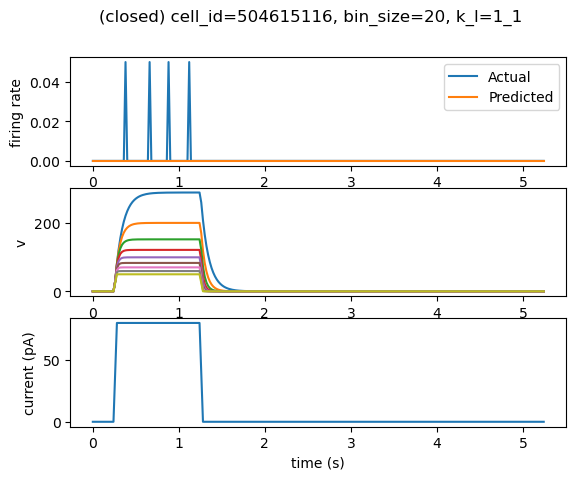

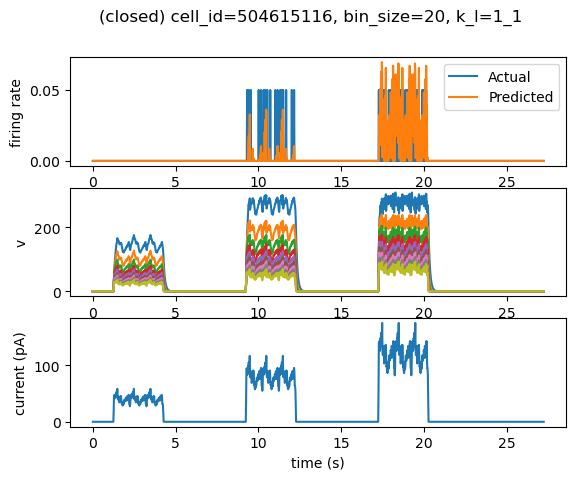

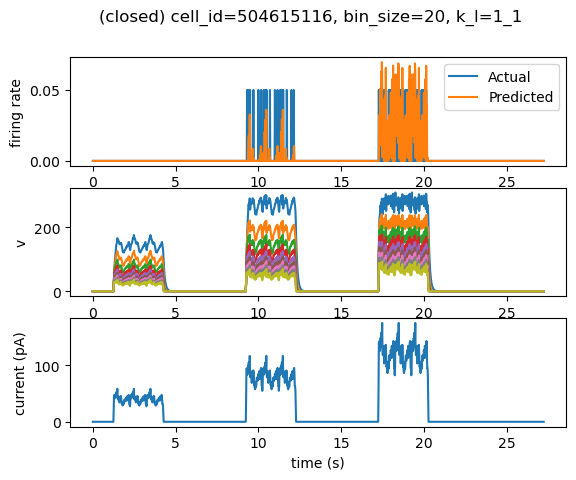

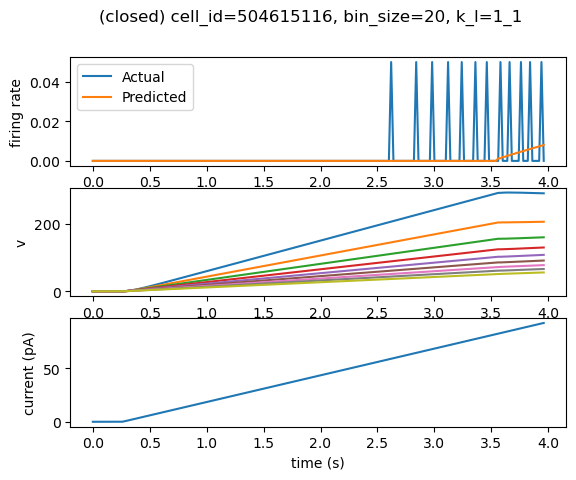

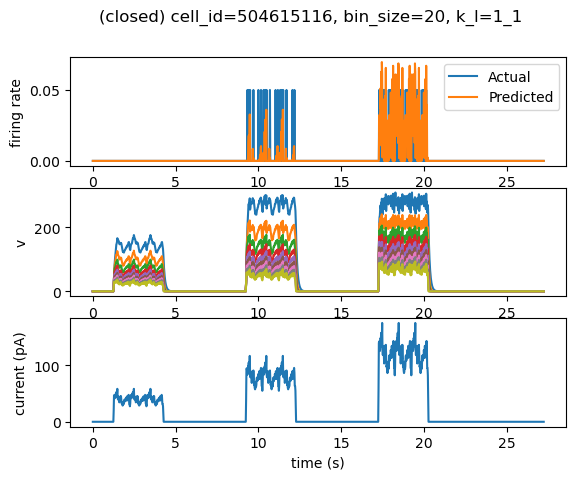

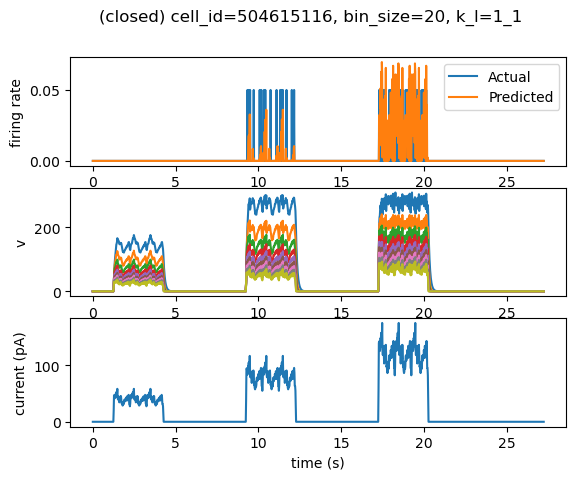

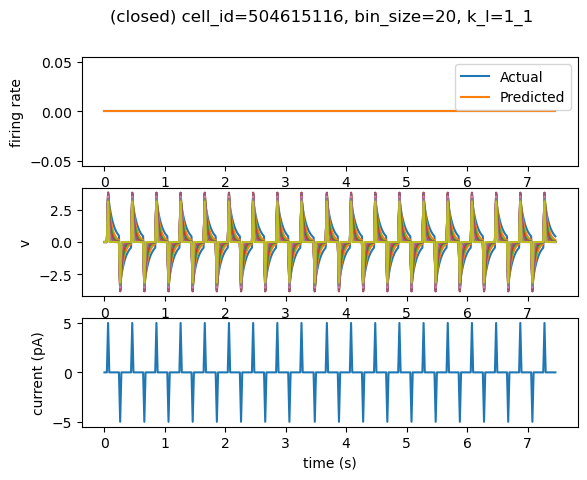

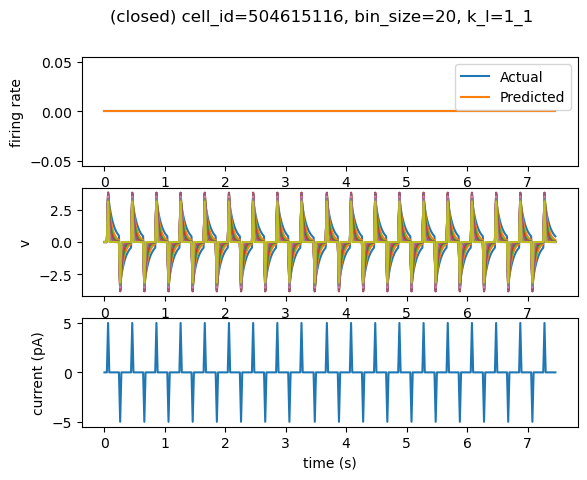

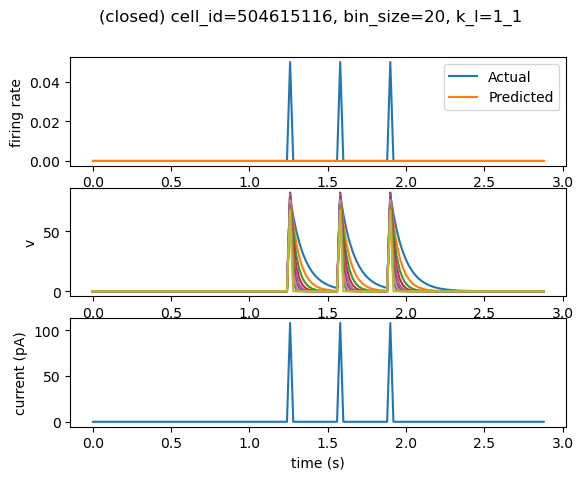

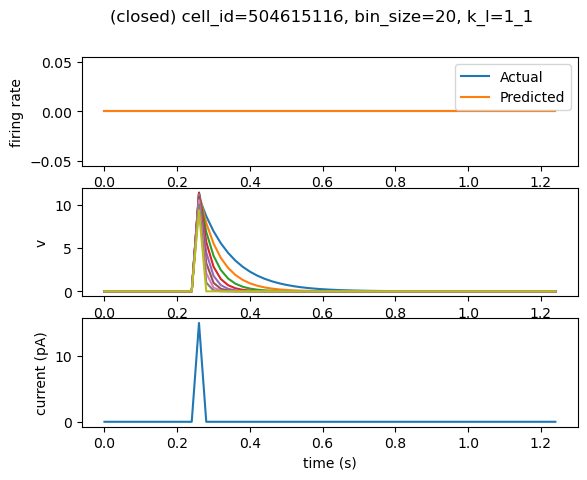

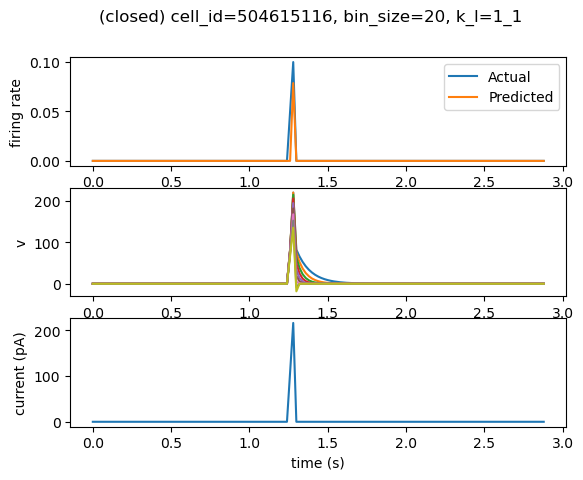

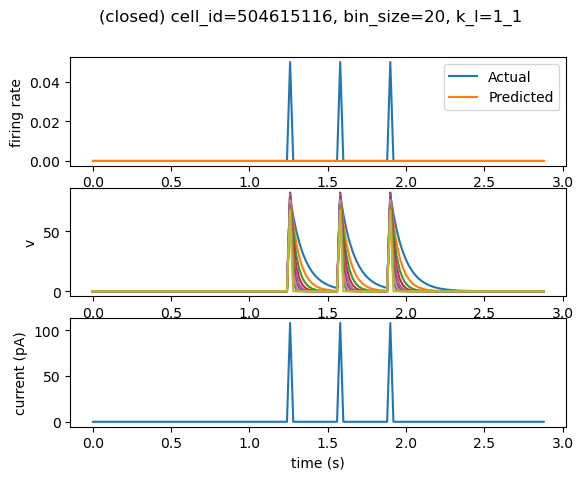

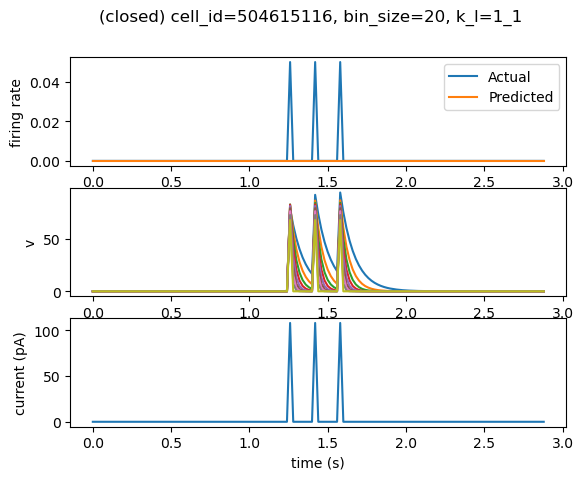

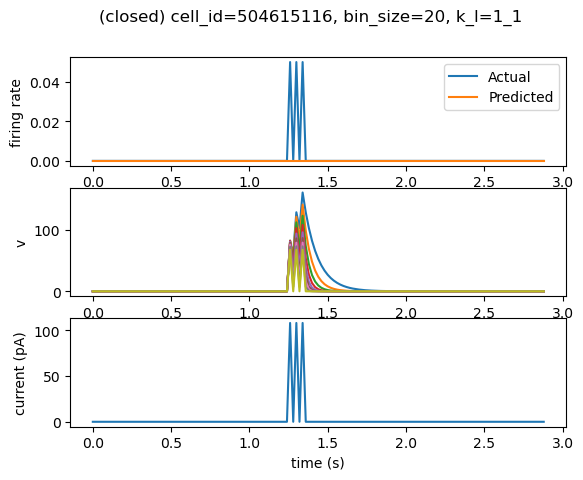

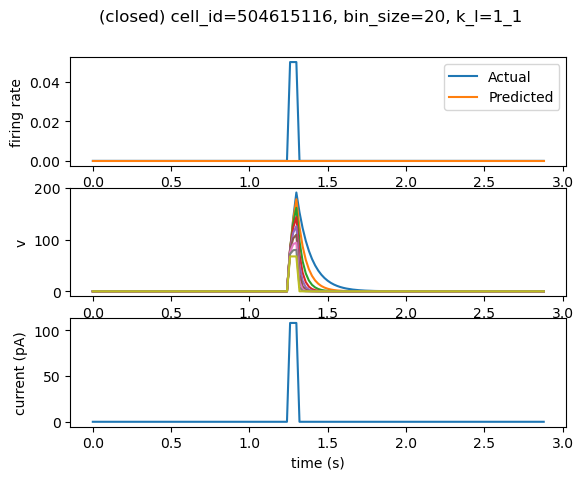

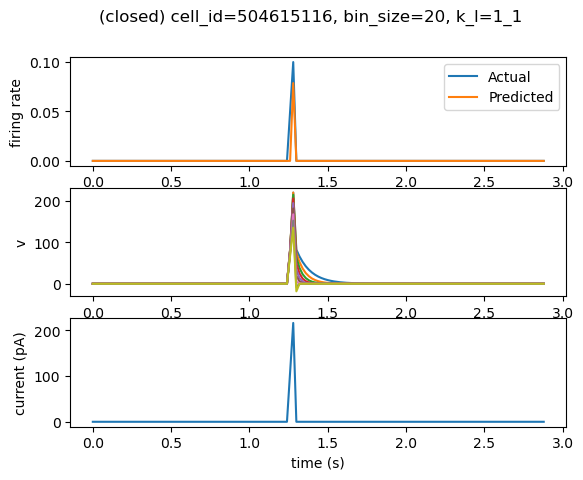

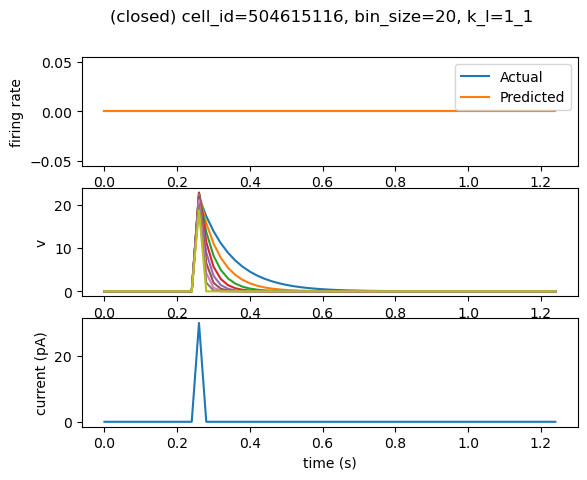

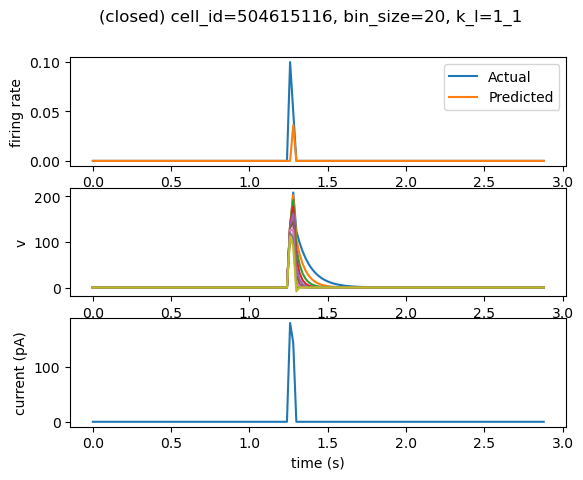

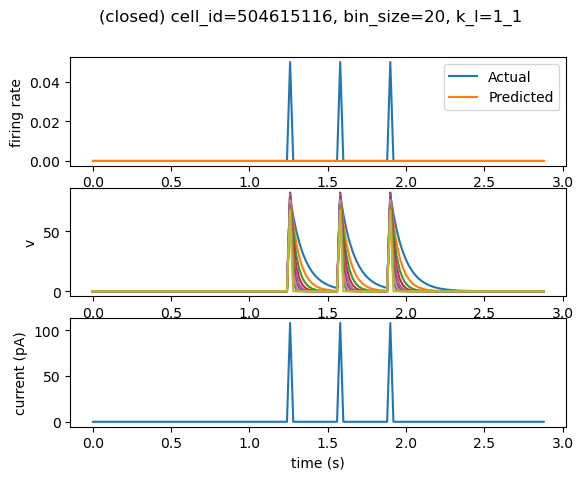

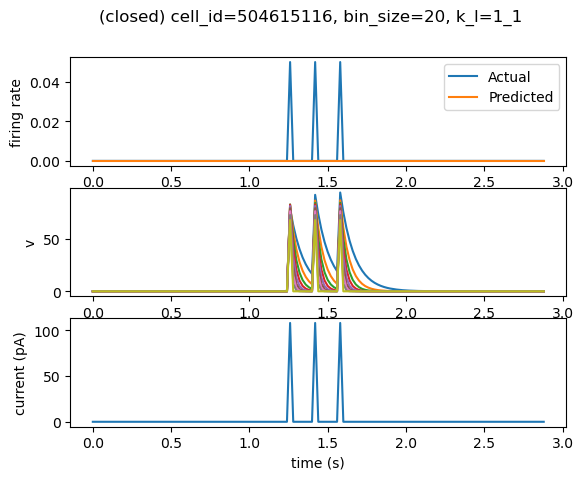

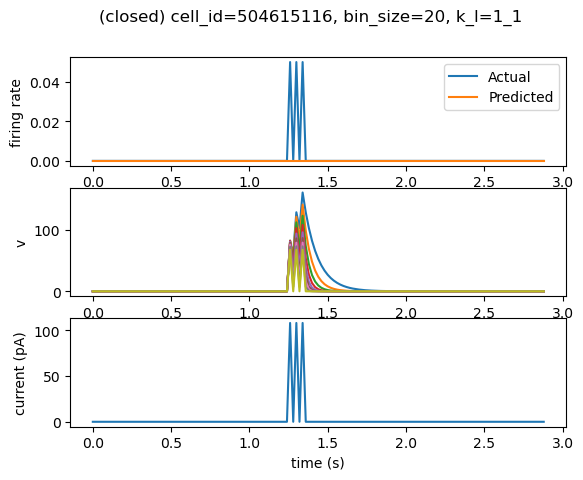

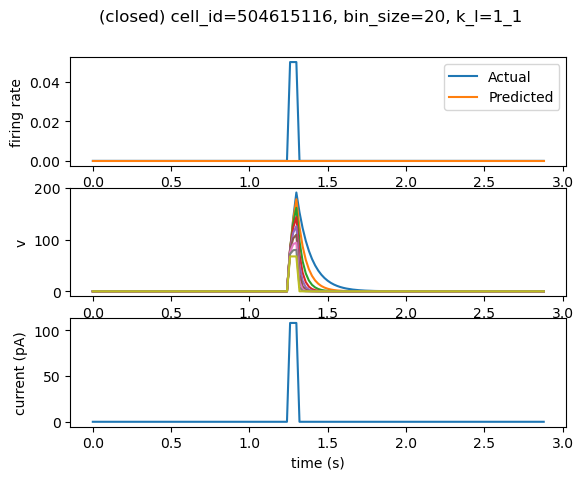

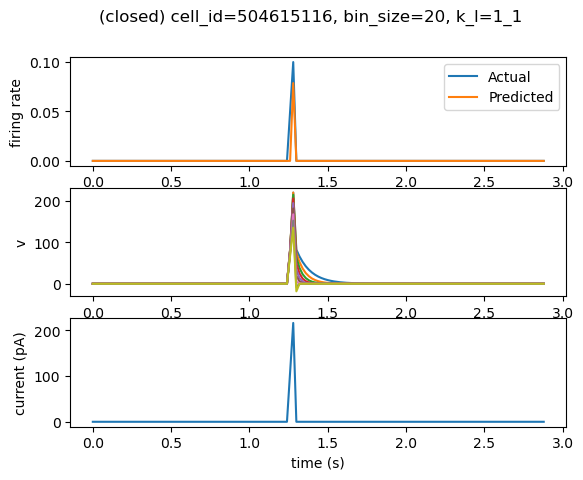

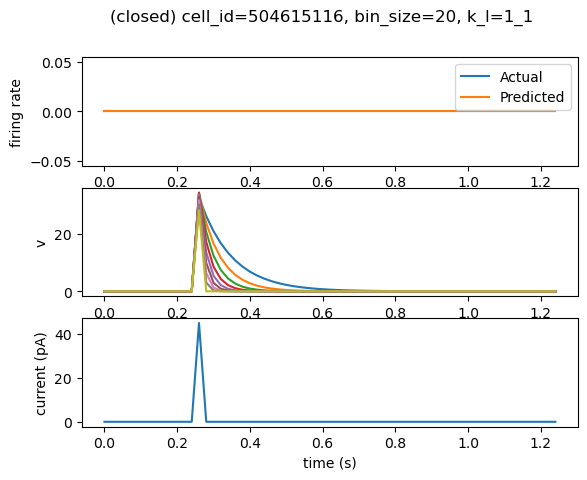

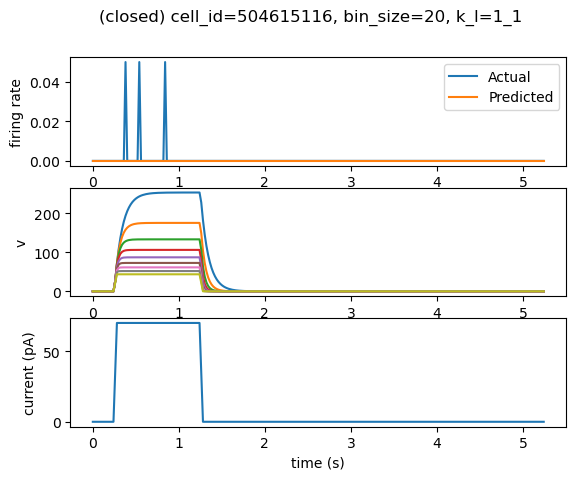

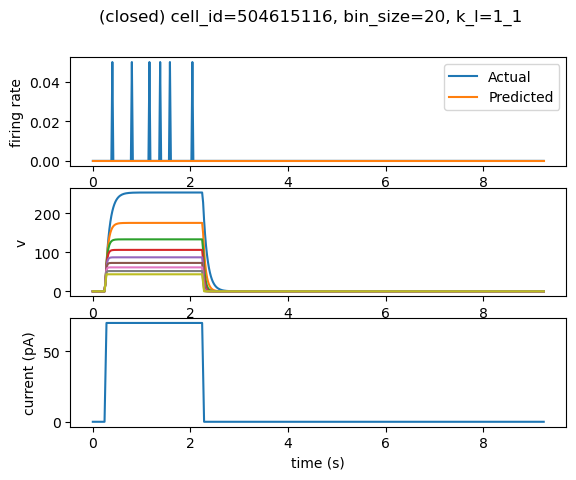

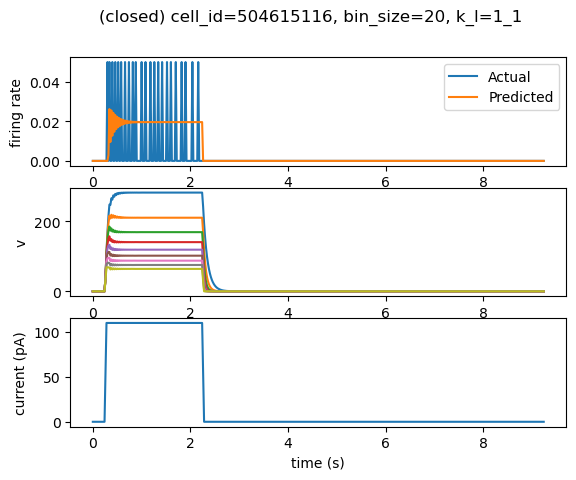

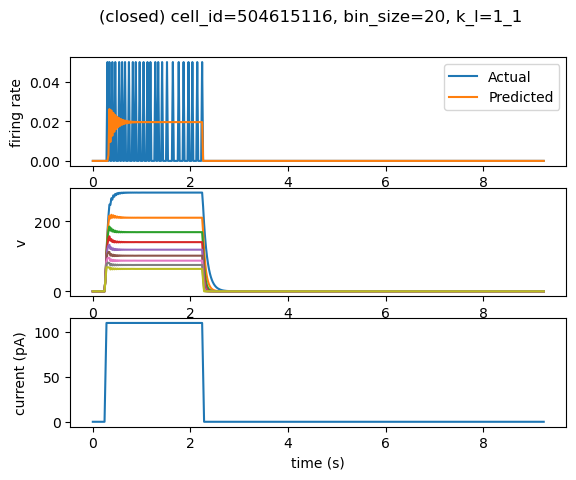

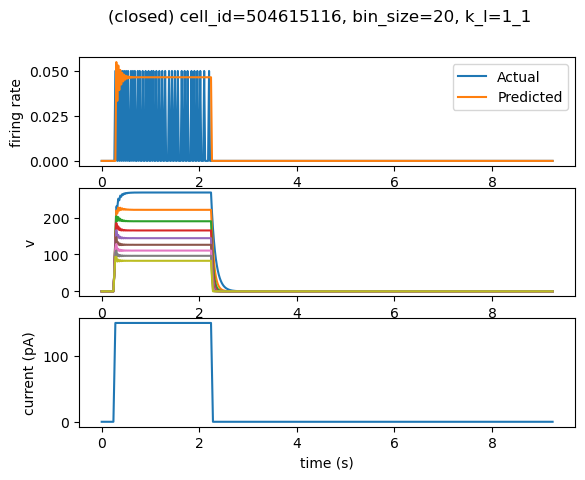

In [15]:
save = False
info = "_multisum"
Is_tr, fs_tr, Is_te, fs_te, ws = get_train_test_data(data, cell_id, bin_size, device=device)
for i in range(len(Is_tr)):
    plot_predictions(model, Is_tr[i], fs_tr[i], evr=None)
    if save:
        plt.savefig(f"figures/model/{cell_id}/bin_size_{bin_size}/{k}_{l}{info}_{i}.png")
        plt.close()

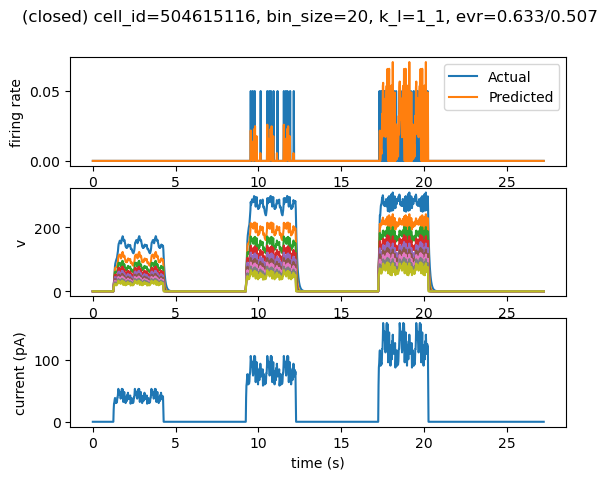

In [16]:
r = explained_variance_ratio(model, Is_te, fs_te, bin_size)
rq = explained_variance_ratio(model, Is_te, fs_te, bin_size, quantize=True)
plot_predictions(model, Is_te[0], fs_te[0], evr=(r, rq))
if save:
    plt.savefig(f"figures/model/{cell_id}/bin_size_{bin_size}/{k}_{l}{info}_noise2.png")
    plt.close()

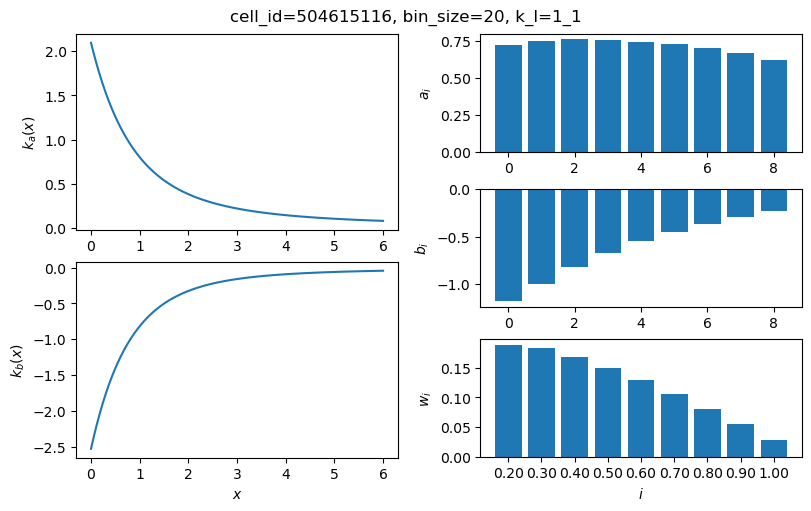

In [17]:
plot_kernel(model)
if save:
    plt.savefig(f"figures/model/{cell_id}/bin_size_{bin_size}/{k}_{l}{info}_kernel.png")
    plt.close()